# Part 1
## EDA


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [10]:
logins = pd.read_json('logins.json')
logins['login_time'] = pd.to_datetime(logins['login_time'])
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [11]:
logins.set_index('login_time', inplace=True)
login_counts = logins.resample('15T').size()

login_counts.head()

login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
Freq: 15T, dtype: int64

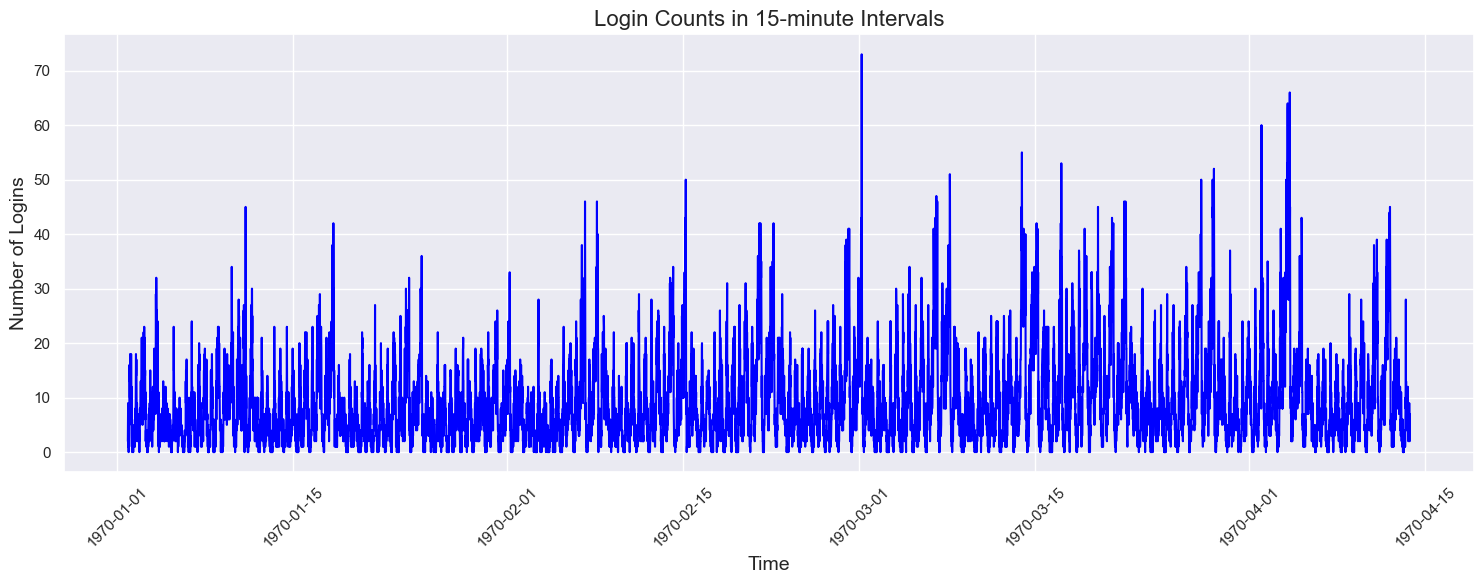

In [15]:

sns.set(style="darkgrid")

plt.figure(figsize=(15, 6))
plt.plot(login_counts.index, login_counts, color='blue')
plt.title('Login Counts in 15-minute Intervals', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Number of Logins', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

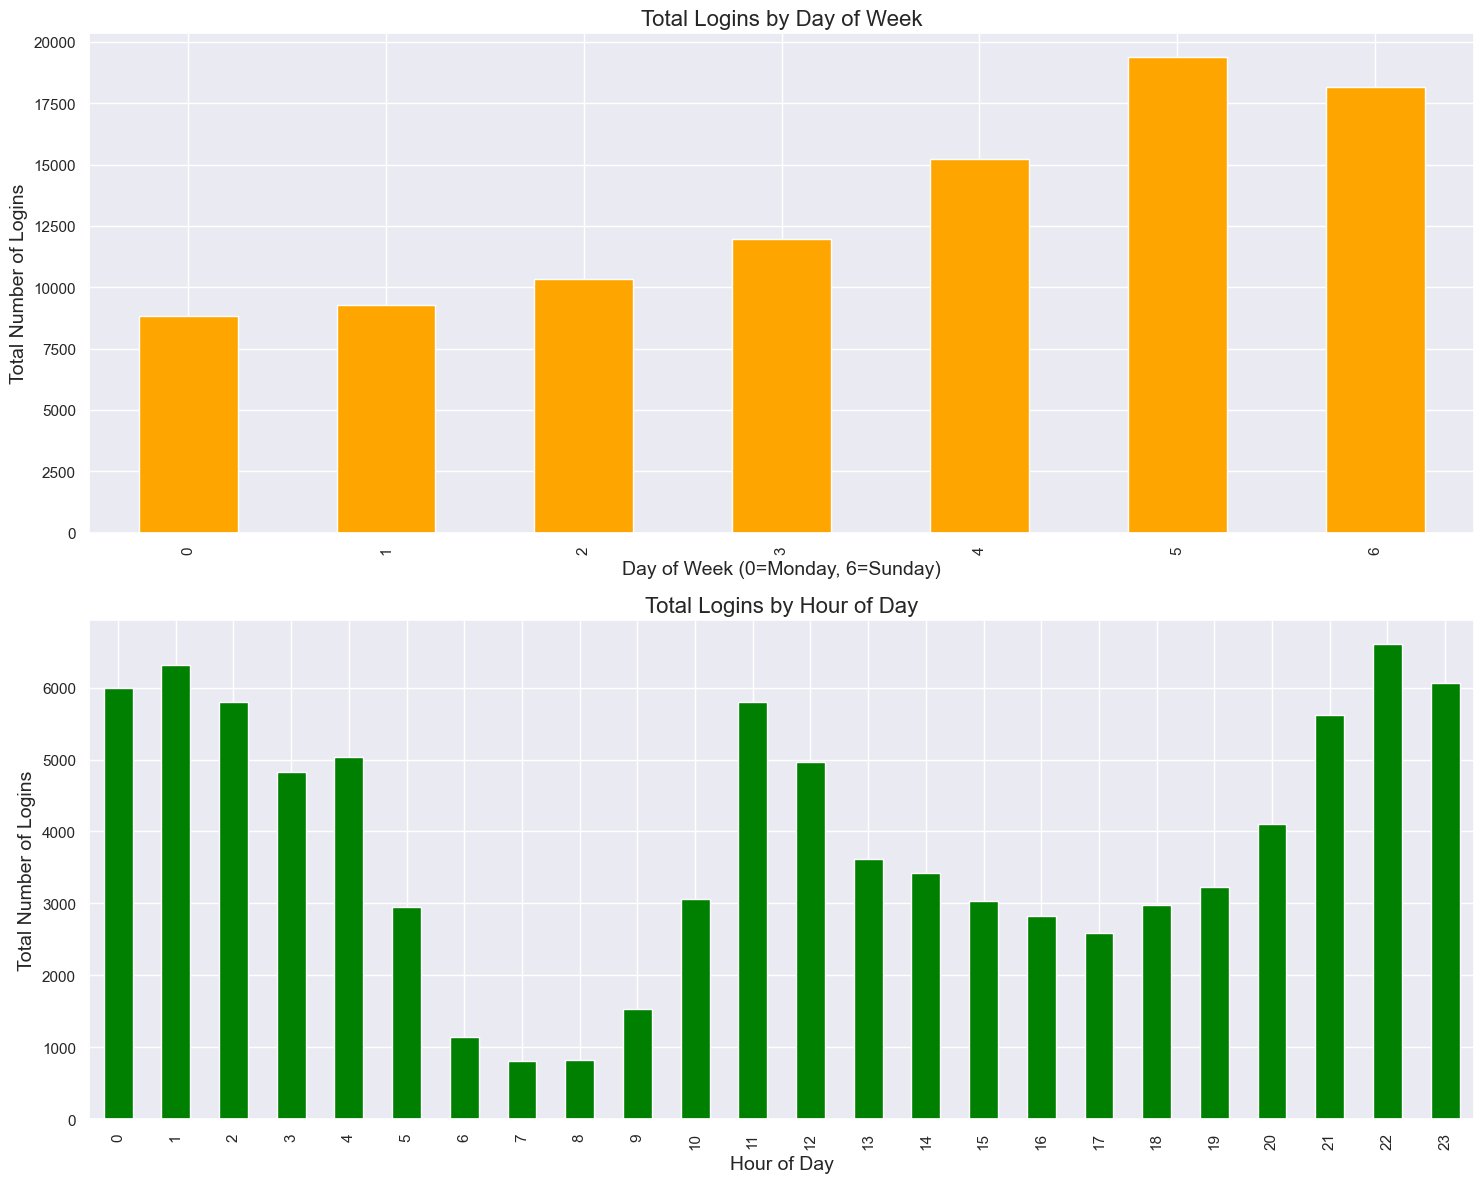

In [16]:
# Extracting day of week and hour from the index for further analysis
login_counts_df = login_counts.to_frame(name='count')
login_counts_df['day_of_week'] = login_counts_df.index.dayofweek
login_counts_df['hour'] = login_counts_df.index.hour

# Aggregating data by day of week and by hour for analysis
weekly_pattern = login_counts_df.groupby('day_of_week')['count'].sum()
daily_pattern = login_counts_df.groupby('hour')['count'].sum()

# Plotting the weekly and daily patterns
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

# Weekly pattern
weekly_pattern.plot(ax=axes[0], kind='bar', color='orange')
axes[0].set_title('Total Logins by Day of Week', fontsize=16)
axes[0].set_xlabel('Day of Week (0=Monday, 6=Sunday)', fontsize=14)
axes[0].set_ylabel('Total Number of Logins', fontsize=14)

# Daily pattern
daily_pattern.plot(ax=axes[1], kind='bar', color='green')
axes[1].set_title('Total Logins by Hour of Day', fontsize=16)
axes[1].set_xlabel('Hour of Day', fontsize=14)
axes[1].set_ylabel('Total Number of Logins', fontsize=14)

plt.tight_layout()
plt.show()


#### Weekly Trends:
There seems to be a ramping up of logins as you get closer to the weekend
#### Daily Cycles:
There are peaks in the hours of 11AM and Midnight, signifying people login around lunch or before bed


# Part 2
## Experiment and metrics


### Key Measure of Success:

Cross-city trips: The increase in the number of trips that start in one city and end in the other.

### Implementation: 
Reimburse toll costs for a set period and track the number of cross-city trips.

Pre-experiment Phase: Collect data on cross-city trips before the policy implementation for a specific period (e.g., one month).

Experiment Phase: Implement the toll reimbursement policy for a similar duration and collect the same data.

Two-Sample T-Test: A standard two-sample t-test can be used to compare the means of cross city trips between the two cities

### Interpretation:

Significant Increase in Cross-City Trips: If the test results show a statistically significant increase, it suggests the policy is effective. Recommendations would then focus on optimizing and possibly expanding the policy.

No Significant Change or Decrease: If there's no significant change or a decrease in cross-city trips, the policy may not be as effective as intended. Further investigation into barriers or alternative strategies would be necessary.

Caveat: The variances of cross-city trips in the two periods are assumed to be equal

# Part 3
## Predictive modeling


In [19]:
data = pd.read_json("ultimate_data_challenge.json")
print(data.head())


             city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  
0         46.2      3.67                   

In [20]:
data['signup_date'] = pd.to_datetime(data['signup_date'])
data['last_trip_date'] = pd.to_datetime(data['last_trip_date'])


In [22]:
from datetime import timedelta

# Assuming this as the date when data was pulled
pull_date = data['last_trip_date'].max()  
data['retained'] = (pull_date - data['last_trip_date']) <= timedelta(days=30)

In [23]:
data = data.fillna(method='ffill')

/var/folders/f0/5p55p_9s6jj9135xj8n1pjq40000gn/T/ipykernel_89766/917065080.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


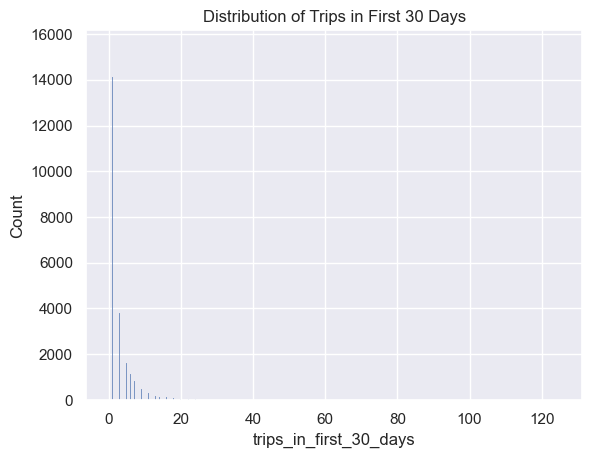

Retention Rate: 0.38


In [24]:
#Plotting distribution of trips in the first 30 days
sns.histplot(data['trips_in_first_30_days'])
plt.title('Distribution of Trips in First 30 Days')
plt.show()

# Calculate the fraction of observed users who were retained
retention_rate = data['retained'].mean()
print(f'Retention Rate: {retention_rate:.2f}')

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Selecting features and target variable
X = data.drop('retained', axis=1)
y = data['retained']

In [29]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression())])

model.fit(X_train, y_train)

predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.72      0.88      0.79      9379
        True       0.68      0.43      0.52      5621

    accuracy                           0.71     15000
   macro avg       0.70      0.65      0.66     15000
weighted avg       0.71      0.71      0.69     15000



In [31]:
feature_names = (numeric_features.tolist() + 
                 list(model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)))
coefficients = model.named_steps['classifier'].coef_[0]

# Mapping features to their coefficients
feature_importance_dict = dict(zip(feature_names, coefficients))
sorted_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Displaying feature coefficients
print("Feature coefficients:")
for feature, coef in sorted_importances:
    print(f"{feature}: {coef}")

Feature coefficients:
city_King's Landing: 0.8439681484307734
trips_in_first_30_days: 0.5072467560402877
phone_iPhone: 0.37321782204454595
surge_pct: 0.0298375728379608
weekday_pct: -0.008104246440788932
avg_rating_of_driver: -0.030556879167457997
avg_surge: -0.031523508286646004
avg_rating_by_driver: -0.05895517408130768
avg_dist: -0.17153647838161656
city_Winterfell: -0.36943830290421403
phone_Android: -0.7137036050562205
city_Astapor: -0.8150156285382335


city_King's Landing (0.844): Being in King's Landing significantly increases the likelihood of retention. This suggests that users in King's Landing have a higher tendency to stay active on the platform.
In comparison , Qinterfell and Astapor are less likely to be retained compared to King's Landing

trips_in_first_30_days (0.507): The more trips a user takes in their first 30 days, the higher their likelihood of retention. This indicates the importance of initial engagement.

phone_Android (-0.714): Android users are significantly less likely to be retained compared to iPhone users. This could point to a difference in user experience on Android devices or demographic differences.

There is a strong effect of city in retention, more tagetted ads or promotions in other cities like winterfell might prove beneficial

Encouraging new users to take more trips in their first 30 days could improve retention.

The difference in retention between iPhone and Android users suggests that investing in the Android app's user experience could be beneficial.